### Summary as of 27 Jan 
- I tried different package to read pdf, and pdftotext works best for the transcripts files
- There are two format types. One is fancier. 
- My next step is to parse the fancier files.

### Summary as of 1st Feb
**Parse fancy files**

- the basic unit: each paragraph spoken by one person (i.e. the content divided by dotted line)
- clean those words that are repeated and obviously useless
- Words appeared in the front page and CORPORATE PARTICIPANTS session are repeated and contain no information

**Next step (postponed)**

- topic modeling (proof of concept)
- parse the rest transcripts
- optimize text preprocessing (if needed)

### Summary as of 9th Feb
**As discussed on 3rd Feb, the input of dynamic topic modeling are files, so I postponed parsing transcripts into paragraphs.**

- I downloaded all transcripts from 2015-2019 
- First topic modeling result

**Next step**
- It looks like the result is heavily tilted by the top words, so I will try to remove some of the top words 

## (9th Feb) Preprocessing all transcripts for LDA and dynamic topic modeling

In [30]:
import pdftotext
import os
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
%matplotlib inline  

def get_text(filepath):
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    return(text)

In [34]:
%%time

path = os.getcwd() + '\data\Transcripts'
years = os.listdir(path)

# get all filenames and the text in the files
files = pd.DataFrame()
for year in years:
    filenames = os.listdir(path + "\\" + year)
    filepaths = [path + "\\" + year + "\\" + filename for filename in filenames]
    texts = [get_text(path) for path in filepaths]
    tmp = pd.DataFrame([filenames, texts]).T
    files = pd.concat([files, tmp], ignore_index=True)

files.columns = ["filename", "text"]

Wall time: 2.15 s


In [42]:
%%time
files["tokens"] = files["text"].map(nltk.word_tokenize)
files["tokens_count"] = files["tokens"].map(len)

Wall time: 3.69 s


#### Decide what words to be deleted

In [155]:
from itertools import chain
all_tokens = list(chain.from_iterable(files["tokens"]))
all_tokens = pd.Series(all_tokens)
tokens_count = all_tokens.value_counts()
len(tokens_count)

11937

In [68]:
unique_tokens = pd.DataFrame()
unique_tokens["token"] = tokens_count.index
unique_tokens["counts"] = tokens_count.values

punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
unique_tokens["punctuation"] = unique_tokens["token"].map(lambda x: x in punctuation)

stop_words = set(stopwords.words('english'))
unique_tokens["stop_words"] = unique_tokens["token"].map(lambda x: x.lower() in stop_words)

unique_tokens["only_twice"] = unique_tokens["counts"].map(lambda x: x <= 2)

unique_tokens["len"] = unique_tokens["token"].map(len)
unique_tokens["too_short"] = unique_tokens["len"] <= 2 # this might eliminate US and UK
unique_tokens["too_long"] = unique_tokens["len"] >= 16 

unique_tokens["apostrophe_comma"] = unique_tokens["token"].map(lambda x: '\'' in x or ',' in x)

removing = (unique_tokens["punctuation"] == True) | (unique_tokens["stop_words"] == True) \
| (unique_tokens["only_twice"] == True) | (unique_tokens["too_short"] == True) \
| (unique_tokens["too_long"] == True) | (unique_tokens["apostrophe_comma"] == True)

remain_token = unique_tokens[~removing]

# remain_token[remain_token["token"].map(lambda x: x[0].isupper())]

removing_words = unique_tokens[removing]["token"]

In [156]:
len(removing_words)

6351

#### Visualize remaining words

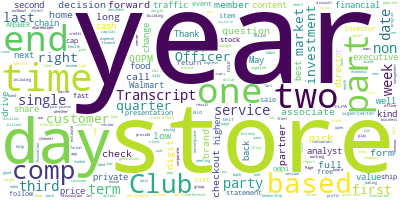

In [161]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(remain_token['token'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

#### Preparing data for LDA

In [172]:
%%time
## need to optimize here
files["cleansed_tokens"] = files["tokens"].map(lambda x: [word for word in x if word not in removing_words.values])

In [176]:
files["corpe"] = files["cleansed_tokens"].map(lambda x: ', '.join(x))

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(files["corpe"])

<48x4758 sparse matrix of type '<class 'numpy.int64'>'
	with 58192 stored elements in Compressed Sparse Row format>

In [181]:
%%time
from sklearn.decomposition import LatentDirichletAllocation as LDA

number_topics = 10
number_words = 10

lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)

Wall time: 958 ms


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=33, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [182]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_topics(lda, count_vectorizer, number_words)


Topic #0:
reaction resilient cashiers characterized quantities afterwards intelligent regular rise magnitude

Topic #1:
reaction resilient cashiers characterized quantities afterwards intelligent regular rise magnitude

Topic #2:
reaction resilient cashiers characterized quantities afterwards intelligent regular rise magnitude

Topic #3:
walmart inc think chief officer executive president vice financial factset

Topic #4:
think walmart business one really things way going like want

Topic #5:
reuters thomson stores inc think walmart mart wal going really

Topic #6:
reuters thomson year customers company stores 2015 inc continue going

Topic #7:
walmart business year flipkart quarter customers growth brett sales question

Topic #8:
current year think really going company change walmart one lot

Topic #9:
walmart sales year quarter percent comp growth customers stores business


**reference:** Topic Modeling in Python: Latent Dirichlet Allocation (LDA) https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
# %%time
# from pyLDAvis import sklearn as sklearn_lda
# import pickle 
# import pyLDAvis
# LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
# LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
# with open(LDAvis_data_filepath, 'w') as f:
#         pickle.dump(LDAvis_prepared, f)
        
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath) as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

**Note:** I am not sure if I should take out tokens with capitalized first letter

I think countries are important, but I also think ppl's name are not important

## The following is work before 9th Feb

In [270]:
import pdftotext
import os
import pandas as pd

def is_fancy(filepath):
    check_words = ["Corrected Transcript",
                  "www.callstreet.com",
                  "FactSet CallStreet, LLC"]
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    if all([ check_word in text for check_word in check_words]):
        return("fancy")
    else:
        return("plain")
    
def get_fp_cp(fp):
    output = list()
    for item in fp[fp.index("CORPORATE PARTICIPANTS"):]:
        if "Walmart" in item:
            for x in item.split("."):
                output = output + x.split(",")
            for x in item.split("-"):
                output = output + x.split("   ")
            for x in item.split("-"):
                output = output + x.split(".")
            for x in item.split("   "):
                output = output + x.split(",")
        else: 
            output = output + item.split()
    return([item.strip() for item in output if len(item) > 1]) 

In [2]:
path = os.getcwd() + '\data\Transcripts2019'
files = os.listdir(path)

In [9]:
files = pd.DataFrame(files, columns=["filename"])
files["type"] = files["filename"].map(lambda x: is_fancy(path + "\\" + x))
files

,filename,type
0,20190219_earningcall_2019Q4.pdf,fancy
1,20190305_conference.pdf,plain
2,20190306_conference.PDF,fancy
3,20190312_conference.pdf,fancy
4,20190516_earningcall_2020Q1.pdf,plain
5,20190530_conference.pdf,fancy
6,20190607_investmentcommunity.pdf,plain
7,20190611_conference.pdf,fancy
8,20190815_earningcall_2020Q2.pdf,plain
9,20190904_conference.pdf,fancy


### Parse fancy files
- the basic unit: each paragraph spoken by one person (i.e. the content divided by dotted line)
- clean those words that are repeated and obviously useless
- Words appeared in the front page and CORPORATE PARTICIPANTS session are repeated and contain no information

In [287]:
def parse_fancy_para(filepath):
    """ return a dataframe, each row is a paragraph spoken by one person
    """ 
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)

    tmp = text.split("........................................\
..............................................................\
..............................................................\
..................................................................................")

    # process words appeared in the front page and CORPORATE PARTICIPANTS section
    fp = [item.strip() for item in tmp[0].split("\r\n") if len(item)>=1]

    to_be_removed = [fp[0], fp[1], fp[3]] + \
                    fp[2].split() + \
                    [x for x in fp[5].split(" ") if len(x) >= 1] + \
                    get_fp_cp(fp)

    to_be_removed_df = pd.DataFrame(set(to_be_removed))
    to_be_removed_df["len"] = to_be_removed_df[0].map(lambda x: len(x))
    to_be_removed_df = to_be_removed_df.sort_values(["len"], ascending = False)

    for item in to_be_removed_df[0]:
        for i in range(1, len(tmp)):
            tmp[i] = tmp[i].replace(item, '')
            tmp[i] = tmp[i].replace("\r\n", '').lstrip(", ")

    return(pd.DataFrame(tmp))

In [288]:
fancy = files[ files["type"] == "fancy" ]

test = pd.DataFrame()
for filename in fancy["filename"]:
    filepath = path + "\\" + filename
    test = pd.concat([test, parse_fancy_para(filepath)], ignore_index=True)

In [289]:
test

,0
0,...
1,OTHER Simeon Ari Gutman ...
2,Thank you. Good morning and welcome to 's four...
3,"Good morning, everyone, and thanks for joining..."
4,"You bet. Thanks, Doug. Good morning, everybody..."
5,QUESTION AND ANSWER SECTIONOperator: Thank you...
6,"Simeon Ari GutmanAnalyst, Morgan Stanley & Co...."
7,"AYeah, thanks, Simeon. We've talked a lot over..."
8,10 ...
9,"AYeah, Simeon, this is Doug. I think the headl..."


### Below is working space: trying to optimize deletion of CORPORATE PARTICIPANTS section

In [285]:
fancy = files[ files["type"] == "fancy" ]
filename = fancy["filename"].iloc[1]
filepath = path + "\\" + filename

pdfFileObj = open(filepath,'rb')
pdf = pdftotext.PDF(pdfFileObj)
text = "\n\n".join(pdf)

tmp = text.split("........................................\
..............................................................\
..............................................................\
..................................................................................")

# process words appeared in the front page and CORPORATE PARTICIPANTS section
fp = [item.strip() for item in tmp[0].split("\r\n") if len(item)>=1]

to_be_removed = [fp[0], fp[1], fp[3]] + \
                fp[2].split() + \
                [x for x in fp[5].split(" ") if len(x) >= 1] + \
                get_fp_cp(fp)

to_be_removed_df = pd.DataFrame(set(to_be_removed))
to_be_removed_df["len"] = to_be_removed_df[0].map(lambda x: len(x))
to_be_removed_df = to_be_removed_df.sort_values(["len"], ascending = False)

for item in to_be_removed_df[0]:
    for i in range(1, len(tmp)):
        tmp[i] = tmp[i].replace(item, '')
        tmp[i] = tmp[i].replace("\r\n", '').lstrip(", ")

In [284]:
to_be_removed_df = pd.DataFrame(set(to_be_removed))
to_be_removed_df["len"] = to_be_removed_df[0].map(lambda x: len(x))
to_be_removed_df = to_be_removed_df.sort_values(["len"], ascending = False)
to_be_removed_df[0]

5     UBS Securities LLC                            ...
10    Analyst, UBS Securities LLC                   ...
13       President & Chief Executive Officer-Walmart US
25             Chief Financial Officer-Walmart US & EVP
20              UBS Global Consumer & Retail Conference
36                  President & Chief Executive Officer
0                       Walmart US & EVP, Walmart, Inc.
1                        Walmart US & EVP, Walmart, Inc
23                          Analyst, UBS Securities LLC
7                             Walmart US, Walmart, Inc.
6                              Walmart US, Walmart, Inc
14                              Chief Financial Officer
33                                 Corrected Transcript
35                                   www.callstreet.com
32                                   UBS Securities LLC
4                                         1-877-FACTSET
2                                          PARTICIPANTS
11                                          06-M